# Fluidity Local Model: Startup Shear Flow

## Learning Objectives

1. Understand startup shear protocol for thixotropic yield-stress fluids
2. Learn stress overshoot mechanism as a thixotropic signature
3. Generate synthetic startup data from calibrated parameters
4. Fit startup transient using NLSQ optimization
5. Perform Bayesian inference with NUTS warm-start
6. Visualize fluidity evolution f(t) during stress growth

## Prerequisites

- Notebook 01 (flow curve calibration for parameter initialization)
- examples/basic/01_quickstart.ipynb
- examples/bayesian/01_bayesian_inference.ipynb

## Expected Runtime

- **Fast mode** (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- **Production mode** (NUM_CHAINS=4, NUM_SAMPLES=2000): ~8-12 minutes

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time
import warnings
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Add utils to path


from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityLocal

# Add examples/utils to path for tutorial utilities (robust path resolution)
# Works whether CWD is project root, examples/, or examples/fluidity/
import rheojax
_rheojax_root = os.path.dirname(os.path.dirname(rheojax.__file__))
_utils_path = os.path.join(_rheojax_root, "examples", "utils")
if os.path.exists(_utils_path) and _utils_path not in sys.path:
    sys.path.insert(0, _utils_path)

from fluidity_tutorial_utils import (
    compute_fit_quality,
    generate_synthetic_startup,
    get_fluidity_param_names,
    load_fluidity_parameters,
    print_convergence_summary,
    print_parameter_comparison,
    save_fluidity_results,
    set_model_parameters,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: Startup Shear Flow

### Startup Protocol

In startup shear, a **constant shear rate** γ̇ is suddenly applied to a material initially at rest. The stress σ(t) and fluidity f(t) evolve via coupled ODEs:

$$
\frac{d\sigma}{dt} = G\left(\dot{\gamma} - \sigma f(t)\right)
$$

$$
\frac{df}{dt} = \frac{f_{\text{eq}} - f}{\theta} + a|\dot{\gamma}|^{n_{\text{rejuv}}}(f_{\text{inf}} - f)
$$

### Stress Overshoot Mechanism

The **stress overshoot** is a hallmark of thixotropic materials:

1. **Initial Response** (t ≈ 0): Material is "structured" with low fluidity f ≈ f_eq → stress grows linearly σ ≈ Gγ̇t
2. **Peak Overshoot** (t ≈ t_peak): Stress reaches maximum σ_max > σ_ss as structure begins to break
3. **Breakdown** (t > t_peak): Rejuvenation term dominates → f increases → stress decays
4. **Steady State** (t → ∞): f → f_ss, σ → σ_ss = τ_y + K|γ̇|^n (Herschel-Bulkley)

### Physical Interpretation

- **Overshoot magnitude** (σ_max - σ_ss) / σ_ss: Degree of structural build-up
- **Time to peak** t_peak: Inverse structural breakdown rate ~ 1/(a|γ̇|^n)
- **Steady-state fluidity**: f_ss = (f_eq/θ + a|γ̇|^n f_inf) / (1/θ + a|γ̇|^n)

### Model Assumptions

- Homogeneous flow (local model, no spatial gradients)
- Scalar fluidity (no orientation tensors)
- Instantaneous strain application at t=0

## 3. Load Calibrated Parameters

We attempt to load previously calibrated parameters from the flow_curve notebook (NB 01). If not available, we use physically reasonable default values for a yield-stress fluid.

In [4]:
# Attempt to load calibrated parameters from flow_curve notebook
try:
    calib_params = load_fluidity_parameters("local", "flow_curve")
    print("Loaded calibrated parameters from flow_curve:")
    for name, val in calib_params.items():
        print(f"  {name:10s} = {val:.4g}")
except FileNotFoundError:
    # Use default parameters for a typical yield-stress fluid
    calib_params = {
        "G": 1e6,       # Pa (elastic modulus)
        "tau_y": 100.0, # Pa (yield stress)
        "K": 500.0,     # Pa·s^n (flow consistency)
        "n_flow": 0.5,  # dimensionless (flow exponent)
        "f_eq": 1e-6,   # 1/(Pa·s) (equilibrium fluidity)
        "f_inf": 1e-3,  # 1/(Pa·s) (high-shear fluidity)
        "theta": 10.0,  # s (aging timescale)
        "a": 1.0,       # dimensionless (rejuvenation amplitude)
        "n_rejuv": 1.0, # dimensionless (rejuvenation exponent)
    }
    print("Using default parameters (run flow_curve notebook first for calibrated values):")
    for name, val in calib_params.items():
        print(f"  {name:10s} = {val:.4g}")

# Get parameter names for this model variant
param_names = get_fluidity_param_names("local")
print(f"\nModel variant: local (parameters: {len(param_names)})")

Loaded calibrated parameters from flow_curve:
  G          = 1e+06
  tau_y      = 1000
  K          = 1000
  n_flow     = 0.5
  f_eq       = 1e-06
  f_inf      = 0.001999
  theta      = 10
  a          = 1
  n_rejuv    = 1

Model variant: local (parameters: 9)


## 4. Generate Synthetic Startup Data

Generate synthetic startup data at γ̇ = 1.0 s⁻¹ using the calibrated model with 3% Gaussian noise. This emulates realistic experimental measurements with measurement uncertainty.

In [5]:
# Create calibrated "true" model
model_true = FluidityLocal()
set_model_parameters(model_true, calib_params)
model_true.fitted_ = True

# Generate synthetic data at γ̇ = 1.0 s⁻¹
GAMMA_DOT = 1.0  # s⁻¹
T_END = 10.0     # s
N_POINTS = 100
NOISE_LEVEL = 0.03  # 3%
SEED = 42

t_data, stress_data = generate_synthetic_startup(
    model_true,
    gamma_dot=GAMMA_DOT,
    t_end=T_END,
    n_points=N_POINTS,
    noise_level=NOISE_LEVEL,
    seed=SEED,
)

print(f"Generated {N_POINTS} startup data points at γ̇={GAMMA_DOT} s⁻¹")
print(f"Time range: [{t_data.min():.3f}, {t_data.max():.2f}] s")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")
print(f"Noise level: {NOISE_LEVEL*100}%")

# Compute expected steady-state stress
tau_y = calib_params["tau_y"]
K = calib_params["K"]
n = calib_params["n_flow"]
sigma_ss_expected = tau_y + K * GAMMA_DOT**n
print(f"\nExpected steady-state stress: {sigma_ss_expected:.2f} Pa")
print(f"Peak stress (overshoot): {stress_data.max():.2f} Pa")
print(f"Overshoot ratio: {(stress_data.max() / sigma_ss_expected - 1)*100:.1f}%")

Generated 100 startup data points at γ̇=1.0 s⁻¹
Time range: [0.010, 10.00] s
Stress range: [6.28, 5501.47] Pa
Noise level: 3.0%

Expected steady-state stress: 2000.00 Pa
Peak stress (overshoot): 5501.47 Pa
Overshoot ratio: 175.1%


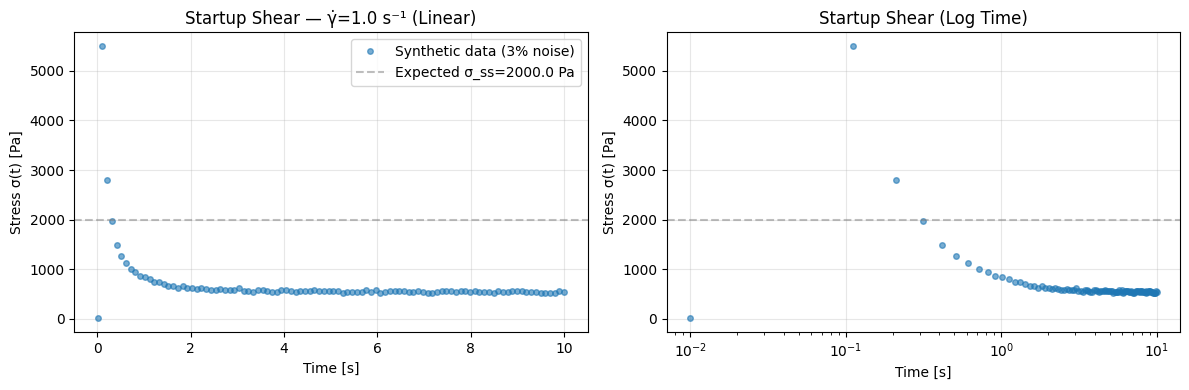

In [6]:
# Visualize synthetic data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale
ax1.plot(t_data, stress_data, "o", markersize=4, alpha=0.6, label="Synthetic data (3% noise)")
ax1.axhline(sigma_ss_expected, color="gray", linestyle="--", alpha=0.5, label=f"Expected σ_ss={sigma_ss_expected:.1f} Pa")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress σ(t) [Pa]")
ax1.set_title(f"Startup Shear — γ̇={GAMMA_DOT} s⁻¹ (Linear)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale (early time detail)
ax2.semilogx(t_data, stress_data, "o", markersize=4, alpha=0.6)
ax2.axhline(sigma_ss_expected, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress σ(t) [Pa]")
ax2.set_title("Startup Shear (Log Time)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## 5. NLSQ Fitting

### 5.1 Fit Startup Transient

Fit the startup stress growth using NLSQ optimization. We must specify `test_mode='startup'` and `gamma_dot=1.0` to activate the transient ODE solver.

In [7]:
# Initialize model
model = FluidityLocal()

# Fit with NLSQ
t0_fit = time.time()
model.fit(
    t_data,
    stress_data,
    test_mode="startup",
    gamma_dot=GAMMA_DOT,
    method='scipy')
t_nlsq = time.time() - t0_fit

# Compute fit quality
stress_pred = model.predict(t_data, test_mode="startup", gamma_dot=GAMMA_DOT)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa")
print("\nFitted parameters (NLSQ):")
print("=" * 60)
print(f"{'Parameter':<12s}  {'Fitted':<12s}  {'True':<12s}  {'Rel. Error'}")
print("-" * 60)
for name in param_names:
    fitted_val = model.parameters.get_value(name)
    true_val = calib_params.get(name, float('nan'))
    rel_err = abs(fitted_val - true_val) / true_val * 100 if true_val != 0 else float('nan')
    print(f"{name:<12s}  {fitted_val:<12.4g}  {true_val:<12.4g}  {rel_err:>6.1f}%")

NLSQ fit time: 18.17 s
R²: 0.976673
RMSE: 87.25 Pa

Fitted parameters (NLSQ):
Parameter     Fitted        True          Rel. Error
------------------------------------------------------------
G             5.282e+05     1e+06           47.2%
tau_y         2414          1000           141.4%
K             1012          1000             1.2%
n_flow        1.992         0.5            298.4%
f_eq          4.415e-06     1e-06          341.3%
f_inf         0.001814      0.001999         9.2%
theta         14.83         10              48.3%
a             1.039         1                3.9%
n_rejuv       1             1                0.0%


### 5.2 Visualize NLSQ Fit

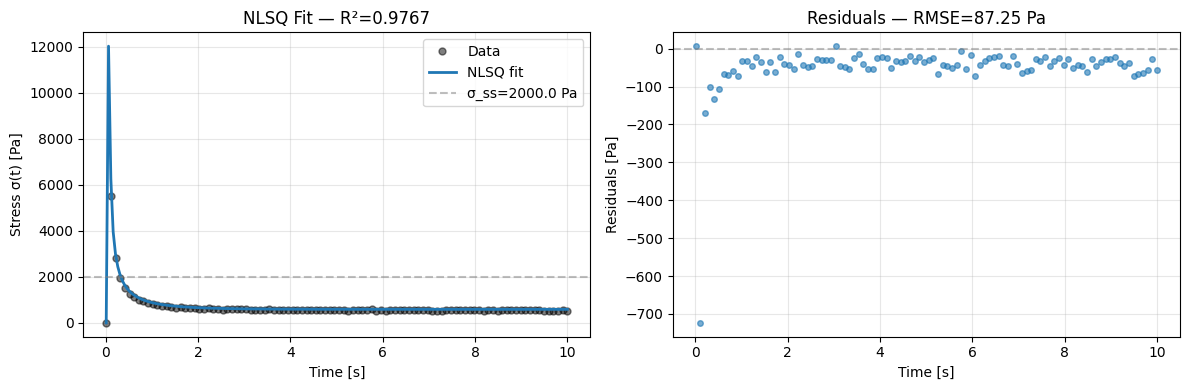

In [8]:
# Generate fine time grid for smooth prediction
t_fine = np.linspace(t_data.min(), t_data.max(), 200)

# Set protocol for prediction
model._gamma_dot_applied = GAMMA_DOT
model._test_mode = "startup"
stress_pred = model.predict(t_fine)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale
ax1.plot(t_data, stress_data, "ko", markersize=5, alpha=0.5, label="Data")
ax1.plot(t_fine, stress_pred, "-", lw=2, color="C0", label="NLSQ fit")
ax1.axhline(sigma_ss_expected, color="gray", linestyle="--", alpha=0.5, label=f"σ_ss={sigma_ss_expected:.1f} Pa")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress σ(t) [Pa]")
ax1.set_title(f"NLSQ Fit — R²={metrics['R2']:.4f}")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residuals
stress_pred_data = model.predict(t_data)
residuals = stress_data - np.asarray(stress_pred_data).flatten()
ax2.plot(t_data, residuals, "o", markersize=4, alpha=0.6)
ax2.axhline(0, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Residuals [Pa]")
ax2.set_title(f"Residuals — RMSE={metrics['RMSE']:.2f} Pa")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

### 5.3 Fluidity Evolution

Visualize the underlying fluidity field f(t) during startup. This shows how the material transitions from structured (low f) to flowing (high f) state.

In [9]:
# Check if model stored trajectory
if hasattr(model, "_trajectory") and model._trajectory is not None:
    traj = model._trajectory
    t_traj = traj["t"]
    f_traj = traj["f"]

    # Compute steady-state fluidity
    f_eq_fit = model.parameters.get_value("f_eq")
    f_inf_fit = model.parameters.get_value("f_inf")
    theta_fit = model.parameters.get_value("theta")
    a_fit = model.parameters.get_value("a")
    n_rejuv_fit = model.parameters.get_value("n_rejuv")

    rate_term = a_fit * GAMMA_DOT**n_rejuv_fit
    f_ss = (f_eq_fit / theta_fit + rate_term * f_inf_fit) / (1.0 / theta_fit + rate_term)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(t_traj, f_traj, "-", lw=2, label="Fluidity f(t)")
    ax.axhline(f_eq_fit, color="C1", linestyle="--", alpha=0.7, label=f"f_eq={f_eq_fit:.2e}")
    ax.axhline(f_inf_fit, color="C2", linestyle="--", alpha=0.7, label=f"f_inf={f_inf_fit:.2e}")
    ax.axhline(f_ss, color="gray", linestyle=":", alpha=0.5, label=f"f_ss={f_ss:.2e}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Fluidity f(t) [1/(Pa·s)]")
    ax.set_title(f"Fluidity Evolution During Startup (γ̇={GAMMA_DOT} s⁻¹)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("No trajectory data stored. Fluidity evolution not available.")

No trajectory data stored. Fluidity evolution not available.


## 6. Bayesian Inference

### 6.1 Run NUTS with NLSQ Warm-Start

**Critical**: Use NLSQ fit as `initial_values` for fast MCMC convergence. Set `test_mode='startup'` to ensure correct likelihood computation.

In [10]:
# Extract NLSQ estimates as warm-start
initial_values = {name: model.parameters.get_value(name) for name in param_names}
print("Warm-start values (from NLSQ):")
for name, val in initial_values.items():
    print(f"  {name:10s} = {val:.4g}")

# Bayesian configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production mode

print(f"\nRunning NUTS: {NUM_CHAINS} chain(s), {NUM_WARMUP} warmup, {NUM_SAMPLES} samples")

# Run Bayesian inference
t0 = time.time()
result = model.fit_bayesian(
    t_data,
    stress_data,
    test_mode="startup",
    gamma_dot=GAMMA_DOT,  # CRITICAL: must pass protocol-specific argument
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values (from NLSQ):
  G          = 5.282e+05
  tau_y      = 2414
  K          = 1012
  n_flow     = 1.992
  f_eq       = 4.415e-06
  f_inf      = 0.001814
  theta      = 14.83
  a          = 1.039
  n_rejuv    = 1

Running NUTS: 1 chain(s), 200 warmup, 500 samples


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [02:12<25:38:47, 132.08s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   0%|          | 2/700 [04:29<26:09:42, 134.93s/it, 1 steps of size 9.40e-02. acc. prob=0.00]

warmup:   0%|          | 3/700 [05:40<20:33:15, 106.16s/it, 1 steps of size 3.66e-03. acc. prob=0.00]

warmup:   1%|          | 4/700 [05:41<12:25:57, 64.31s/it, 3 steps of size 2.12e-03. acc. prob=0.25] 

warmup:   1%|          | 5/700 [05:43<8:06:42, 42.02s/it, 63 steps of size 1.45e-03. acc. prob=0.40]

warmup:   1%|          | 6/700 [05:58<6:21:05, 32.95s/it, 319 steps of size 9.58e-04. acc. prob=0.49]

warmup:   1%|          | 7/700 [06:08<4:53:14, 25.39s/it, 255 steps of size 7.13e-04. acc. prob=0.55]

warmup:   1%|          | 8/700 [06:39<5:12:46, 27.12s/it, 511 steps of size 6.60e-04. acc. prob=0.61]

warmup:   1%|▏         | 9/700 [07:08<5:18:28, 27.65s/it, 511 steps of size 5.30e-04. acc. prob=0.64]

warmup:   1%|▏         | 10/700 [08:17<7:43:45, 40.33s/it, 1023 steps of size 1.20e-04. acc. prob=0.63]

warmup:   2%|▏         | 11/700 [09:28<9:32:20, 49.84s/it, 1023 steps of size 1.25e-04. acc. prob=0.67]

warmup:   2%|▏         | 12/700 [10:40<10:48:08, 56.52s/it, 1023 steps of size 1.34e-04. acc. prob=0.69]

warmup:   2%|▏         | 13/700 [11:52<11:40:51, 61.21s/it, 1023 steps of size 1.26e-04. acc. prob=0.71]

warmup:   2%|▏         | 14/700 [13:10<12:37:10, 66.22s/it, 1023 steps of size 1.21e-04. acc. prob=0.73]

warmup:   2%|▏         | 15/700 [14:28<13:18:26, 69.94s/it, 1023 steps of size 9.84e-05. acc. prob=0.74]

warmup:   2%|▏         | 16/700 [15:45<13:39:59, 71.93s/it, 1023 steps of size 1.09e-04. acc. prob=0.76]

warmup:   2%|▏         | 17/700 [17:07<14:14:10, 75.04s/it, 1023 steps of size 9.84e-05. acc. prob=0.77]

warmup:   3%|▎         | 18/700 [18:23<14:15:36, 75.27s/it, 1023 steps of size 5.04e-05. acc. prob=0.77]

warmup:   3%|▎         | 19/700 [19:25<13:28:40, 71.25s/it, 1023 steps of size 4.65e-05. acc. prob=0.78]

warmup:   3%|▎         | 20/700 [20:27<12:57:15, 68.58s/it, 1023 steps of size 5.16e-05. acc. prob=0.79]

warmup:   3%|▎         | 21/700 [21:26<12:23:19, 65.68s/it, 1023 steps of size 5.82e-05. acc. prob=0.80]

warmup:   3%|▎         | 22/700 [22:25<11:59:35, 63.68s/it, 1023 steps of size 6.10e-05. acc. prob=0.80]

warmup:   3%|▎         | 23/700 [23:23<11:39:51, 62.03s/it, 1023 steps of size 6.94e-05. acc. prob=0.81]

warmup:   3%|▎         | 24/700 [24:21<11:25:42, 60.86s/it, 1023 steps of size 5.80e-05. acc. prob=0.82]

warmup:   4%|▎         | 25/700 [25:18<11:09:38, 59.52s/it, 1023 steps of size 4.93e-05. acc. prob=0.82]

warmup:   4%|▎         | 26/700 [26:11<10:46:39, 57.57s/it, 1023 steps of size 4.70e-05. acc. prob=0.82]

warmup:   4%|▍         | 27/700 [27:03<10:28:32, 56.04s/it, 1023 steps of size 5.32e-05. acc. prob=0.83]

warmup:   4%|▍         | 28/700 [27:56<10:18:22, 55.21s/it, 1023 steps of size 5.98e-05. acc. prob=0.84]

warmup:   4%|▍         | 29/700 [28:48<10:03:39, 53.98s/it, 1023 steps of size 4.11e-05. acc. prob=0.84]

warmup:   4%|▍         | 30/700 [29:36<9:44:33, 52.35s/it, 1023 steps of size 4.61e-05. acc. prob=0.84] 

warmup:   4%|▍         | 31/700 [30:24<9:30:01, 51.12s/it, 1023 steps of size 5.22e-05. acc. prob=0.85]

warmup:   5%|▍         | 32/700 [31:15<9:28:41, 51.08s/it, 1023 steps of size 5.92e-05. acc. prob=0.85]

warmup:   5%|▍         | 33/700 [32:05<9:24:39, 50.79s/it, 1023 steps of size 5.02e-05. acc. prob=0.85]

warmup:   5%|▍         | 34/700 [32:58<9:27:59, 51.17s/it, 1023 steps of size 5.55e-05. acc. prob=0.86]

warmup:   5%|▌         | 35/700 [33:48<9:24:58, 50.97s/it, 1023 steps of size 6.09e-05. acc. prob=0.86]

warmup:   5%|▌         | 36/700 [34:41<9:29:21, 51.45s/it, 1023 steps of size 6.45e-05. acc. prob=0.86]

warmup:   5%|▌         | 37/700 [35:37<9:44:44, 52.92s/it, 1023 steps of size 6.14e-05. acc. prob=0.86]

warmup:   5%|▌         | 38/700 [38:04<14:56:04, 81.22s/it, 1023 steps of size 6.90e-05. acc. prob=0.87]

warmup:   6%|▌         | 39/700 [40:43<19:12:04, 104.58s/it, 1023 steps of size 7.74e-05. acc. prob=0.87]

warmup:   6%|▌         | 40/700 [43:27<22:24:09, 122.20s/it, 1023 steps of size 8.21e-05. acc. prob=0.87]

warmup:   6%|▌         | 41/700 [45:33<22:37:10, 123.57s/it, 1023 steps of size 8.52e-05. acc. prob=0.88]

warmup:   6%|▌         | 42/700 [47:24<21:53:28, 119.77s/it, 1023 steps of size 8.52e-05. acc. prob=0.88]

warmup:   6%|▌         | 43/700 [49:12<21:12:11, 116.18s/it, 1023 steps of size 8.13e-05. acc. prob=0.88]

warmup:   6%|▋         | 44/700 [50:48<20:03:48, 110.11s/it, 1023 steps of size 8.19e-05. acc. prob=0.88]

warmup:   6%|▋         | 45/700 [52:44<20:22:40, 112.00s/it, 1023 steps of size 8.01e-05. acc. prob=0.88]

warmup:   7%|▋         | 46/700 [54:28<19:53:45, 109.52s/it, 1023 steps of size 8.55e-05. acc. prob=0.89]

warmup:   7%|▋         | 47/700 [56:16<19:46:19, 109.00s/it, 1023 steps of size 9.37e-05. acc. prob=0.89]

warmup:   7%|▋         | 48/700 [57:53<19:04:38, 105.33s/it, 1023 steps of size 9.46e-05. acc. prob=0.89]

warmup:   7%|▋         | 49/700 [1:00:29<21:48:02, 120.56s/it, 1023 steps of size 9.51e-05. acc. prob=0.89]

warmup:   7%|▋         | 50/700 [1:02:48<22:45:53, 126.08s/it, 1023 steps of size 5.74e-05. acc. prob=0.89]

warmup:   7%|▋         | 51/700 [1:04:09<20:16:45, 112.49s/it, 1023 steps of size 6.14e-05. acc. prob=0.89]

warmup:   7%|▋         | 52/700 [1:06:17<21:05:29, 117.18s/it, 1023 steps of size 6.74e-05. acc. prob=0.89]

warmup:   8%|▊         | 53/700 [1:08:29<21:52:23, 121.71s/it, 1023 steps of size 7.42e-05. acc. prob=0.89]

warmup:   8%|▊         | 54/700 [1:10:31<21:52:59, 121.95s/it, 1023 steps of size 6.74e-05. acc. prob=0.89]

warmup:   8%|▊         | 55/700 [1:12:41<22:15:37, 124.24s/it, 1023 steps of size 6.74e-05. acc. prob=0.90]

warmup:   8%|▊         | 56/700 [1:14:42<22:02:20, 123.20s/it, 1023 steps of size 7.20e-05. acc. prob=0.90]

warmup:   8%|▊         | 57/700 [1:16:29<21:07:57, 118.32s/it, 1023 steps of size 7.90e-05. acc. prob=0.90]

warmup:   8%|▊         | 58/700 [1:17:48<18:59:31, 106.50s/it, 1023 steps of size 8.17e-05. acc. prob=0.90]

warmup:   8%|▊         | 59/700 [1:19:43<19:26:48, 109.22s/it, 1023 steps of size 7.90e-05. acc. prob=0.90]

warmup:   9%|▊         | 60/700 [1:22:28<22:22:11, 125.83s/it, 1023 steps of size 8.65e-05. acc. prob=0.90]

warmup:   9%|▊         | 61/700 [1:25:43<26:01:29, 146.62s/it, 1023 steps of size 9.42e-05. acc. prob=0.90]

warmup:   9%|▉         | 62/700 [1:28:22<26:38:33, 150.34s/it, 1023 steps of size 1.01e-04. acc. prob=0.91]

warmup:   9%|▉         | 63/700 [1:30:25<25:09:34, 142.19s/it, 1023 steps of size 1.09e-04. acc. prob=0.91]

warmup:   9%|▉         | 64/700 [1:32:29<24:07:35, 136.57s/it, 1023 steps of size 1.15e-04. acc. prob=0.91]

warmup:   9%|▉         | 65/700 [1:34:36<23:37:48, 133.97s/it, 1023 steps of size 1.22e-04. acc. prob=0.91]

warmup:   9%|▉         | 66/700 [1:36:18<21:53:59, 124.35s/it, 1023 steps of size 1.05e-04. acc. prob=0.91]

warmup:  10%|▉         | 67/700 [1:37:19<18:31:09, 105.32s/it, 1023 steps of size 8.01e-05. acc. prob=0.91]

warmup:  10%|▉         | 68/700 [1:38:16<15:55:09, 90.68s/it, 1023 steps of size 8.71e-05. acc. prob=0.91] 

warmup:  10%|▉         | 69/700 [1:39:13<14:07:17, 80.57s/it, 1023 steps of size 9.45e-05. acc. prob=0.91]

warmup:  10%|█         | 70/700 [1:40:13<13:00:30, 74.33s/it, 1023 steps of size 9.51e-05. acc. prob=0.91]

warmup:  10%|█         | 71/700 [1:41:24<12:49:55, 73.44s/it, 1023 steps of size 1.02e-04. acc. prob=0.91]

warmup:  10%|█         | 72/700 [1:42:40<12:56:28, 74.19s/it, 1023 steps of size 9.14e-05. acc. prob=0.91]

warmup:  10%|█         | 73/700 [1:43:45<12:25:34, 71.35s/it, 1023 steps of size 7.75e-05. acc. prob=0.91]

warmup:  11%|█         | 74/700 [1:44:40<11:33:19, 66.45s/it, 1023 steps of size 8.35e-05. acc. prob=0.91]

warmup:  11%|█         | 75/700 [1:45:34<10:54:11, 62.80s/it, 1023 steps of size 8.63e-05. acc. prob=0.91]

warmup:  11%|█         | 76/700 [1:46:28<10:24:58, 60.09s/it, 1023 steps of size 9.01e-05. acc. prob=0.91]

warmup:  11%|█         | 77/700 [1:47:24<10:11:41, 58.91s/it, 1023 steps of size 9.67e-05. acc. prob=0.92]

warmup:  11%|█         | 78/700 [1:48:23<10:11:02, 58.94s/it, 1023 steps of size 1.04e-04. acc. prob=0.92]

warmup:  11%|█▏        | 79/700 [1:49:22<10:10:58, 59.03s/it, 1023 steps of size 9.24e-05. acc. prob=0.92]

warmup:  11%|█▏        | 80/700 [1:50:19<10:03:50, 58.44s/it, 1023 steps of size 5.74e-05. acc. prob=0.91]

warmup:  12%|█▏        | 81/700 [1:51:17<10:01:55, 58.35s/it, 1023 steps of size 5.26e-05. acc. prob=0.91]

warmup:  12%|█▏        | 82/700 [1:52:14<9:57:21, 58.00s/it, 1023 steps of size 5.42e-05. acc. prob=0.91] 

warmup:  12%|█▏        | 83/700 [1:53:21<10:22:57, 60.58s/it, 1023 steps of size 5.64e-05. acc. prob=0.92]

warmup:  12%|█▏        | 84/700 [1:54:20<10:16:35, 60.06s/it, 1023 steps of size 5.51e-05. acc. prob=0.92]

warmup:  12%|█▏        | 85/700 [1:55:22<10:21:25, 60.63s/it, 1023 steps of size 5.92e-05. acc. prob=0.92]

warmup:  12%|█▏        | 86/700 [1:56:26<10:32:26, 61.80s/it, 1023 steps of size 6.32e-05. acc. prob=0.92]

warmup:  12%|█▏        | 87/700 [1:57:30<10:37:40, 62.41s/it, 1023 steps of size 6.68e-05. acc. prob=0.92]

warmup:  13%|█▎        | 88/700 [1:58:58<11:54:51, 70.08s/it, 1023 steps of size 6.13e-05. acc. prob=0.92]

warmup:  13%|█▎        | 89/700 [2:01:02<14:37:58, 86.22s/it, 1023 steps of size 5.54e-05. acc. prob=0.92]

warmup:  13%|█▎        | 90/700 [2:02:58<16:07:06, 95.13s/it, 1023 steps of size 5.62e-05. acc. prob=0.92]

warmup:  13%|█▎        | 91/700 [2:04:58<17:20:01, 102.46s/it, 1023 steps of size 6.02e-05. acc. prob=0.92]

warmup:  13%|█▎        | 92/700 [2:06:56<18:07:29, 107.32s/it, 1023 steps of size 6.47e-05. acc. prob=0.92]

warmup:  13%|█▎        | 93/700 [2:08:52<18:32:35, 109.98s/it, 1023 steps of size 6.54e-05. acc. prob=0.92]

warmup:  13%|█▎        | 94/700 [2:10:41<18:26:04, 109.51s/it, 1023 steps of size 5.40e-05. acc. prob=0.92]

warmup:  14%|█▎        | 95/700 [2:12:37<18:44:51, 111.56s/it, 1023 steps of size 5.72e-05. acc. prob=0.92]

warmup:  14%|█▎        | 96/700 [2:14:38<19:10:43, 114.31s/it, 1023 steps of size 6.00e-05. acc. prob=0.92]

warmup:  14%|█▍        | 97/700 [2:16:38<19:25:12, 115.94s/it, 1023 steps of size 5.31e-05. acc. prob=0.92]

warmup:  14%|█▍        | 98/700 [2:18:13<18:22:00, 109.83s/it, 1023 steps of size 5.65e-05. acc. prob=0.92]

warmup:  14%|█▍        | 99/700 [2:19:38<17:06:17, 102.46s/it, 1023 steps of size 5.95e-05. acc. prob=0.92]

warmup:  14%|█▍        | 100/700 [2:21:07<16:23:25, 98.34s/it, 1023 steps of size 6.17e-05. acc. prob=0.92]

warmup:  14%|█▍        | 101/700 [2:22:37<15:55:49, 95.74s/it, 1023 steps of size 6.26e-04. acc. prob=0.92]

warmup:  15%|█▍        | 102/700 [2:24:03<15:26:10, 92.93s/it, 1023 steps of size 5.72e-04. acc. prob=0.93]

warmup:  15%|█▍        | 103/700 [2:25:18<14:31:01, 87.54s/it, 1023 steps of size 5.80e-04. acc. prob=0.93]

warmup:  15%|█▍        | 104/700 [2:26:27<13:35:07, 82.06s/it, 1023 steps of size 5.80e-04. acc. prob=0.93]

warmup:  15%|█▌        | 105/700 [2:27:30<12:35:22, 76.17s/it, 1023 steps of size 5.91e-04. acc. prob=0.93]

warmup:  15%|█▌        | 106/700 [2:28:34<11:57:56, 72.52s/it, 1023 steps of size 6.03e-04. acc. prob=0.93]

warmup:  15%|█▌        | 107/700 [2:29:39<11:36:06, 70.43s/it, 1023 steps of size 5.82e-04. acc. prob=0.93]

warmup:  15%|█▌        | 108/700 [2:30:43<11:15:39, 68.48s/it, 1023 steps of size 5.88e-04. acc. prob=0.93]

warmup:  16%|█▌        | 109/700 [2:31:51<11:12:36, 68.29s/it, 1023 steps of size 5.63e-04. acc. prob=0.93]

warmup:  16%|█▌        | 110/700 [2:33:04<11:24:40, 69.63s/it, 1023 steps of size 5.14e-04. acc. prob=0.93]

warmup:  16%|█▌        | 111/700 [2:34:10<11:13:15, 68.58s/it, 1023 steps of size 4.87e-04. acc. prob=0.93]

warmup:  16%|█▌        | 112/700 [2:35:06<10:33:16, 64.62s/it, 1023 steps of size 5.01e-04. acc. prob=0.93]

warmup:  16%|█▌        | 113/700 [2:36:03<10:09:54, 62.34s/it, 1023 steps of size 4.91e-04. acc. prob=0.93]

warmup:  16%|█▋        | 114/700 [2:36:59<9:51:33, 60.57s/it, 1023 steps of size 4.57e-04. acc. prob=0.93] 

warmup:  16%|█▋        | 115/700 [2:37:55<9:37:10, 59.20s/it, 1023 steps of size 4.53e-04. acc. prob=0.93]

warmup:  17%|█▋        | 116/700 [2:38:52<9:28:33, 58.41s/it, 1023 steps of size 4.55e-04. acc. prob=0.93]

warmup:  17%|█▋        | 117/700 [2:39:48<9:22:23, 57.88s/it, 1023 steps of size 4.50e-04. acc. prob=0.93]

warmup:  17%|█▋        | 118/700 [2:40:44<9:15:14, 57.24s/it, 1023 steps of size 4.63e-04. acc. prob=0.93]

warmup:  17%|█▋        | 119/700 [2:41:39<9:09:08, 56.71s/it, 1023 steps of size 4.77e-04. acc. prob=0.93]

warmup:  17%|█▋        | 120/700 [2:42:37<9:09:57, 56.89s/it, 1023 steps of size 4.75e-04. acc. prob=0.93]

warmup:  17%|█▋        | 121/700 [2:43:34<9:11:30, 57.15s/it, 1023 steps of size 4.87e-04. acc. prob=0.93]

warmup:  17%|█▋        | 122/700 [2:44:32<9:11:26, 57.24s/it, 1023 steps of size 4.61e-04. acc. prob=0.94]

warmup:  18%|█▊        | 123/700 [2:45:29<9:08:47, 57.07s/it, 1023 steps of size 4.58e-04. acc. prob=0.94]

warmup:  18%|█▊        | 124/700 [2:46:25<9:06:48, 56.96s/it, 1023 steps of size 4.63e-04. acc. prob=0.94]

warmup:  18%|█▊        | 125/700 [2:47:21<9:01:56, 56.55s/it, 1023 steps of size 4.02e-04. acc. prob=0.94]

warmup:  18%|█▊        | 126/700 [2:48:17<9:00:27, 56.49s/it, 1023 steps of size 4.14e-04. acc. prob=0.94]

warmup:  18%|█▊        | 127/700 [2:49:16<9:07:06, 57.29s/it, 1023 steps of size 4.13e-04. acc. prob=0.94]

warmup:  18%|█▊        | 128/700 [2:50:13<9:04:43, 57.14s/it, 1023 steps of size 4.02e-04. acc. prob=0.94]

warmup:  18%|█▊        | 129/700 [2:51:10<9:02:10, 56.97s/it, 1023 steps of size 4.14e-04. acc. prob=0.94]

warmup:  19%|█▊        | 130/700 [2:52:07<9:01:31, 57.00s/it, 1023 steps of size 4.25e-04. acc. prob=0.94]

warmup:  19%|█▊        | 131/700 [2:53:03<8:57:12, 56.65s/it, 1023 steps of size 3.72e-04. acc. prob=0.94]

warmup:  19%|█▉        | 132/700 [2:53:58<8:52:05, 56.21s/it, 1023 steps of size 3.81e-04. acc. prob=0.94]

warmup:  19%|█▉        | 133/700 [2:54:53<8:48:02, 55.88s/it, 1023 steps of size 3.89e-04. acc. prob=0.94]

warmup:  19%|█▉        | 134/700 [2:55:49<8:46:17, 55.79s/it, 1023 steps of size 3.98e-04. acc. prob=0.94]

warmup:  19%|█▉        | 135/700 [2:56:44<8:44:16, 55.67s/it, 1023 steps of size 3.98e-04. acc. prob=0.94]

warmup:  19%|█▉        | 136/700 [2:57:39<8:42:59, 55.64s/it, 1023 steps of size 4.03e-04. acc. prob=0.94]

warmup:  20%|█▉        | 137/700 [2:58:35<8:41:36, 55.59s/it, 1023 steps of size 4.02e-04. acc. prob=0.94]

warmup:  20%|█▉        | 138/700 [2:59:30<8:40:21, 55.55s/it, 1023 steps of size 3.99e-04. acc. prob=0.94]

warmup:  20%|█▉        | 139/700 [3:00:26<8:38:56, 55.50s/it, 1023 steps of size 3.87e-04. acc. prob=0.94]

warmup:  20%|██        | 140/700 [3:01:21<8:38:05, 55.51s/it, 1023 steps of size 3.79e-04. acc. prob=0.94]

warmup:  20%|██        | 141/700 [3:02:13<8:25:09, 54.22s/it, 1023 steps of size 3.81e-04. acc. prob=0.94]

warmup:  20%|██        | 142/700 [3:03:03<8:15:03, 53.23s/it, 1023 steps of size 3.80e-04. acc. prob=0.94]

warmup:  20%|██        | 143/700 [3:03:54<8:07:30, 52.51s/it, 1023 steps of size 3.75e-04. acc. prob=0.94]

warmup:  21%|██        | 144/700 [3:04:46<8:03:19, 52.16s/it, 1023 steps of size 3.54e-04. acc. prob=0.94]

warmup:  21%|██        | 145/700 [3:05:36<7:57:21, 51.61s/it, 1023 steps of size 3.61e-04. acc. prob=0.94]

warmup:  21%|██        | 146/700 [3:06:27<7:54:01, 51.34s/it, 1023 steps of size 3.70e-04. acc. prob=0.94]

warmup:  21%|██        | 147/700 [3:07:17<7:51:39, 51.17s/it, 1023 steps of size 3.69e-04. acc. prob=0.94]

warmup:  21%|██        | 148/700 [3:08:08<7:48:29, 50.92s/it, 1023 steps of size 3.69e-04. acc. prob=0.94]

warmup:  21%|██▏       | 149/700 [3:08:57<7:43:44, 50.50s/it, 1023 steps of size 3.75e-04. acc. prob=0.94]

warmup:  21%|██▏       | 150/700 [3:09:48<7:43:27, 50.56s/it, 1023 steps of size 3.82e-04. acc. prob=0.94]

warmup:  22%|██▏       | 151/700 [3:10:44<7:56:28, 52.07s/it, 1023 steps of size 3.86e-03. acc. prob=0.94]

warmup:  22%|██▏       | 152/700 [3:11:42<8:14:01, 54.09s/it, 1023 steps of size 3.69e-03. acc. prob=0.95]

warmup:  22%|██▏       | 153/700 [3:12:42<8:28:06, 55.73s/it, 1023 steps of size 2.90e-03. acc. prob=0.94]

warmup:  22%|██▏       | 154/700 [3:13:41<8:36:40, 56.78s/it, 1023 steps of size 2.83e-03. acc. prob=0.95]

warmup:  22%|██▏       | 155/700 [3:14:38<8:35:55, 56.80s/it, 1023 steps of size 2.02e-03. acc. prob=0.94]

warmup:  22%|██▏       | 156/700 [3:15:36<8:38:06, 57.14s/it, 1023 steps of size 1.95e-03. acc. prob=0.94]

warmup:  22%|██▏       | 157/700 [3:16:33<8:37:12, 57.15s/it, 1023 steps of size 1.42e-03. acc. prob=0.94]

warmup:  23%|██▎       | 158/700 [3:17:32<8:39:54, 57.55s/it, 1023 steps of size 1.38e-03. acc. prob=0.94]

warmup:  23%|██▎       | 159/700 [3:18:33<8:48:19, 58.59s/it, 1023 steps of size 1.35e-03. acc. prob=0.95]

warmup:  23%|██▎       | 160/700 [3:19:26<8:33:56, 57.10s/it, 1023 steps of size 1.31e-03. acc. prob=0.95]

warmup:  23%|██▎       | 161/700 [3:20:20<8:23:09, 56.01s/it, 1023 steps of size 1.35e-03. acc. prob=0.95]

warmup:  23%|██▎       | 162/700 [3:21:13<8:14:54, 55.19s/it, 1023 steps of size 1.32e-03. acc. prob=0.95]

warmup:  23%|██▎       | 163/700 [3:22:06<8:07:58, 54.52s/it, 1023 steps of size 1.33e-03. acc. prob=0.95]

warmup:  23%|██▎       | 164/700 [3:22:57<7:58:46, 53.60s/it, 1023 steps of size 1.13e-03. acc. prob=0.95]

warmup:  24%|██▎       | 165/700 [3:23:48<7:48:40, 52.56s/it, 1023 steps of size 1.16e-03. acc. prob=0.95]

warmup:  24%|██▎       | 166/700 [3:24:38<7:41:28, 51.85s/it, 1023 steps of size 9.83e-04. acc. prob=0.95]

warmup:  24%|██▍       | 167/700 [3:25:27<7:33:33, 51.06s/it, 1023 steps of size 9.88e-04. acc. prob=0.95]

warmup:  24%|██▍       | 168/700 [3:26:16<7:28:26, 50.58s/it, 1023 steps of size 1.02e-03. acc. prob=0.95]

warmup:  24%|██▍       | 169/700 [3:27:06<7:25:24, 50.33s/it, 1023 steps of size 9.35e-04. acc. prob=0.95]

warmup:  24%|██▍       | 170/700 [3:27:55<7:19:29, 49.75s/it, 1023 steps of size 9.71e-04. acc. prob=0.95]

warmup:  24%|██▍       | 171/700 [3:28:44<7:18:59, 49.79s/it, 1023 steps of size 9.23e-04. acc. prob=0.95]

warmup:  25%|██▍       | 172/700 [3:29:32<7:12:54, 49.19s/it, 1023 steps of size 8.47e-04. acc. prob=0.95]

warmup:  25%|██▍       | 173/700 [3:30:20<7:08:06, 48.74s/it, 1023 steps of size 7.99e-04. acc. prob=0.95]

warmup:  25%|██▍       | 174/700 [3:31:07<7:03:26, 48.30s/it, 1023 steps of size 7.65e-04. acc. prob=0.95]

warmup:  25%|██▌       | 175/700 [3:31:54<6:59:15, 47.92s/it, 1023 steps of size 7.80e-04. acc. prob=0.95]

warmup:  25%|██▌       | 176/700 [3:32:41<6:55:36, 47.59s/it, 1023 steps of size 7.42e-04. acc. prob=0.95]

warmup:  25%|██▌       | 177/700 [3:33:27<6:49:34, 46.99s/it, 1023 steps of size 7.71e-04. acc. prob=0.95]

warmup:  25%|██▌       | 178/700 [3:34:13<6:46:49, 46.76s/it, 1023 steps of size 7.96e-04. acc. prob=0.95]

warmup:  26%|██▌       | 179/700 [3:35:00<6:45:43, 46.72s/it, 1023 steps of size 8.28e-04. acc. prob=0.95]

warmup:  26%|██▌       | 180/700 [3:35:48<6:49:56, 47.30s/it, 1023 steps of size 8.62e-04. acc. prob=0.95]

warmup:  26%|██▌       | 181/700 [3:36:36<6:50:18, 47.44s/it, 1023 steps of size 8.95e-04. acc. prob=0.95]

warmup:  26%|██▌       | 182/700 [3:37:23<6:49:07, 47.39s/it, 1023 steps of size 9.09e-04. acc. prob=0.95]

warmup:  26%|██▌       | 183/700 [3:38:12<6:53:09, 47.95s/it, 1023 steps of size 9.43e-04. acc. prob=0.95]

warmup:  26%|██▋       | 184/700 [3:39:02<6:56:47, 48.46s/it, 1023 steps of size 9.55e-04. acc. prob=0.95]

warmup:  26%|██▋       | 185/700 [3:39:52<7:00:13, 48.96s/it, 1023 steps of size 9.91e-04. acc. prob=0.95]

warmup:  27%|██▋       | 186/700 [3:40:42<7:01:29, 49.20s/it, 1023 steps of size 9.95e-04. acc. prob=0.95]

warmup:  27%|██▋       | 187/700 [3:41:32<7:01:57, 49.35s/it, 1023 steps of size 9.48e-04. acc. prob=0.95]

warmup:  27%|██▋       | 188/700 [3:42:21<7:00:07, 49.23s/it, 1023 steps of size 8.33e-04. acc. prob=0.95]

warmup:  27%|██▋       | 189/700 [3:43:10<7:00:43, 49.40s/it, 1023 steps of size 8.59e-04. acc. prob=0.95]

warmup:  27%|██▋       | 190/700 [3:44:00<6:59:16, 49.33s/it, 1023 steps of size 8.91e-04. acc. prob=0.95]

warmup:  27%|██▋       | 191/700 [3:44:49<6:59:09, 49.41s/it, 1023 steps of size 9.23e-04. acc. prob=0.95]

warmup:  27%|██▋       | 192/700 [3:45:40<7:02:22, 49.89s/it, 1023 steps of size 9.15e-04. acc. prob=0.95]

warmup:  28%|██▊       | 193/700 [3:46:32<7:05:32, 50.36s/it, 1023 steps of size 9.31e-04. acc. prob=0.95]

warmup:  28%|██▊       | 194/700 [3:47:22<7:05:23, 50.44s/it, 1023 steps of size 9.63e-04. acc. prob=0.95]

warmup:  28%|██▊       | 195/700 [3:48:13<7:05:34, 50.56s/it, 1023 steps of size 9.32e-04. acc. prob=0.95]

warmup:  28%|██▊       | 196/700 [3:49:03<7:03:56, 50.47s/it, 1023 steps of size 9.60e-04. acc. prob=0.95]

warmup:  28%|██▊       | 197/700 [3:49:54<7:03:12, 50.48s/it, 1023 steps of size 9.85e-04. acc. prob=0.95]

warmup:  28%|██▊       | 198/700 [3:50:45<7:04:06, 50.69s/it, 1023 steps of size 9.83e-04. acc. prob=0.95]

warmup:  28%|██▊       | 199/700 [3:51:36<7:03:33, 50.73s/it, 1023 steps of size 9.14e-04. acc. prob=0.95]

warmup:  29%|██▊       | 200/700 [3:52:26<7:00:25, 50.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.95]

sample:  29%|██▊       | 201/700 [3:53:15<6:57:44, 50.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  29%|██▉       | 202/700 [3:54:06<6:57:37, 50.32s/it, 1023 steps of size 9.38e-04. acc. prob=1.00]

sample:  29%|██▉       | 203/700 [3:54:58<6:59:59, 50.70s/it, 1023 steps of size 9.38e-04. acc. prob=1.00]

sample:  29%|██▉       | 204/700 [3:55:48<6:59:26, 50.74s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  29%|██▉       | 205/700 [3:56:40<7:01:53, 51.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  29%|██▉       | 206/700 [3:57:32<7:02:52, 51.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  30%|██▉       | 207/700 [3:58:25<7:04:45, 51.70s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  30%|██▉       | 208/700 [3:59:18<7:08:20, 52.24s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  30%|██▉       | 209/700 [4:00:13<7:14:03, 53.04s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  30%|███       | 210/700 [4:01:07<7:13:52, 53.13s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  30%|███       | 211/700 [4:02:00<7:14:13, 53.28s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  30%|███       | 212/700 [4:02:54<7:14:59, 53.48s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  30%|███       | 213/700 [4:03:46<7:10:15, 53.01s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  31%|███       | 214/700 [4:04:40<7:11:59, 53.33s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  31%|███       | 215/700 [4:05:35<7:13:46, 53.66s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  31%|███       | 216/700 [4:06:28<7:12:30, 53.62s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  31%|███       | 217/700 [4:07:23<7:14:04, 53.92s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  31%|███       | 218/700 [4:08:12<7:01:22, 52.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [4:09:06<7:05:14, 53.05s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [4:10:00<7:06:49, 53.35s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [4:10:54<7:06:37, 53.44s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [4:11:47<7:05:15, 53.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  32%|███▏      | 223/700 [4:12:41<7:04:31, 53.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [4:13:33<7:01:49, 53.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [4:14:25<6:57:30, 52.74s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [4:15:18<6:56:33, 52.73s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  32%|███▏      | 227/700 [4:16:11<6:56:17, 52.81s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  33%|███▎      | 228/700 [4:17:04<6:56:10, 52.90s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [4:17:58<6:57:18, 53.16s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  33%|███▎      | 230/700 [4:18:52<6:59:09, 53.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  33%|███▎      | 231/700 [4:19:47<7:01:06, 53.87s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  33%|███▎      | 232/700 [4:20:41<7:01:55, 54.09s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  33%|███▎      | 233/700 [4:21:38<7:07:17, 54.90s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  33%|███▎      | 234/700 [4:22:36<7:14:18, 55.92s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  34%|███▎      | 235/700 [4:23:34<7:17:29, 56.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  34%|███▎      | 236/700 [4:24:35<7:27:37, 57.88s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  34%|███▍      | 237/700 [4:25:37<7:36:34, 59.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  34%|███▍      | 238/700 [4:26:39<7:41:56, 59.99s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [4:27:40<7:43:00, 60.26s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  34%|███▍      | 240/700 [4:28:41<7:42:45, 60.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [4:29:40<7:38:41, 59.96s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  35%|███▍      | 242/700 [4:30:39<7:36:36, 59.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [4:31:40<7:38:17, 60.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  35%|███▍      | 244/700 [4:32:41<7:39:06, 60.41s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [4:33:41<7:37:16, 60.30s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  35%|███▌      | 246/700 [4:34:44<7:41:14, 60.96s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  35%|███▌      | 247/700 [4:35:46<7:42:44, 61.29s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  35%|███▌      | 248/700 [4:36:48<7:43:17, 61.50s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  36%|███▌      | 249/700 [4:37:49<7:41:48, 61.44s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  36%|███▌      | 250/700 [4:38:50<7:39:35, 61.28s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  36%|███▌      | 251/700 [4:39:51<7:38:35, 61.28s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  36%|███▌      | 252/700 [4:40:53<7:38:11, 61.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  36%|███▌      | 253/700 [4:41:53<7:35:12, 61.10s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  36%|███▋      | 254/700 [4:42:56<7:37:36, 61.56s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [4:43:59<7:39:25, 61.95s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  37%|███▋      | 256/700 [4:44:59<7:35:31, 61.56s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  37%|███▋      | 257/700 [4:46:02<7:36:52, 61.88s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  37%|███▋      | 258/700 [4:47:04<7:35:52, 61.88s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  37%|███▋      | 259/700 [4:48:05<7:33:56, 61.76s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  37%|███▋      | 260/700 [4:49:07<7:32:06, 61.65s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  37%|███▋      | 261/700 [4:50:10<7:34:30, 62.12s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  37%|███▋      | 262/700 [4:51:12<7:33:53, 62.18s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  38%|███▊      | 263/700 [4:52:13<7:28:57, 61.64s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  38%|███▊      | 264/700 [4:53:18<7:34:53, 62.60s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [4:54:30<7:54:15, 65.42s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  38%|███▊      | 266/700 [4:55:34<7:50:46, 65.08s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  38%|███▊      | 267/700 [4:56:35<7:41:56, 64.01s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  38%|███▊      | 268/700 [4:57:37<7:35:37, 63.28s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  38%|███▊      | 269/700 [4:58:38<7:30:16, 62.68s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  39%|███▊      | 270/700 [4:59:39<7:24:52, 62.08s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  39%|███▊      | 271/700 [5:00:42<7:24:56, 62.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  39%|███▉      | 272/700 [5:01:41<7:17:09, 61.28s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [5:02:38<7:07:29, 60.07s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  39%|███▉      | 274/700 [5:03:33<6:56:57, 58.73s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  39%|███▉      | 275/700 [5:04:29<6:50:15, 57.92s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  39%|███▉      | 276/700 [5:05:32<6:58:41, 59.25s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  40%|███▉      | 277/700 [5:06:26<6:47:09, 57.75s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  40%|███▉      | 278/700 [5:07:20<6:37:27, 56.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  40%|███▉      | 279/700 [5:08:15<6:34:56, 56.29s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  40%|████      | 280/700 [5:09:11<6:31:23, 55.91s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  40%|████      | 281/700 [5:10:07<6:30:56, 55.98s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  40%|████      | 282/700 [5:11:03<6:30:10, 56.01s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  40%|████      | 283/700 [5:12:01<6:34:38, 56.78s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  41%|████      | 284/700 [5:12:57<6:31:34, 56.48s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  41%|████      | 285/700 [5:13:58<6:39:05, 57.70s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  41%|████      | 286/700 [5:15:04<6:56:30, 60.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  41%|████      | 287/700 [5:16:08<7:03:21, 61.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  41%|████      | 288/700 [5:17:13<7:08:39, 62.43s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  41%|████▏     | 289/700 [5:18:17<7:11:58, 63.06s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  41%|████▏     | 290/700 [5:19:23<7:15:22, 63.71s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  42%|████▏     | 291/700 [5:20:27<7:14:36, 63.76s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [5:21:32<7:17:39, 64.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  42%|████▏     | 293/700 [5:22:36<7:15:00, 64.13s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  42%|████▏     | 294/700 [5:23:43<7:19:08, 64.90s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  42%|████▏     | 295/700 [5:24:50<7:23:44, 65.74s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  42%|████▏     | 296/700 [5:25:58<7:27:00, 66.39s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  42%|████▏     | 297/700 [5:27:07<7:30:00, 67.00s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  43%|████▎     | 298/700 [5:28:12<7:26:20, 66.62s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  43%|████▎     | 299/700 [5:29:19<7:25:57, 66.73s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  43%|████▎     | 300/700 [5:30:30<7:32:30, 67.88s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  43%|████▎     | 301/700 [5:31:35<7:25:15, 66.96s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  43%|████▎     | 302/700 [5:32:41<7:21:50, 66.61s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  43%|████▎     | 303/700 [5:33:44<7:14:09, 65.61s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  43%|████▎     | 304/700 [5:34:45<7:04:36, 64.33s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  44%|████▎     | 305/700 [5:35:47<6:59:01, 63.65s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  44%|████▎     | 306/700 [5:36:49<6:54:17, 63.09s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  44%|████▍     | 307/700 [5:37:50<6:49:29, 62.52s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  44%|████▍     | 308/700 [5:38:52<6:46:23, 62.20s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  44%|████▍     | 309/700 [5:39:52<6:41:18, 61.58s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  44%|████▍     | 310/700 [5:40:53<6:38:35, 61.32s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  44%|████▍     | 311/700 [5:41:54<6:38:41, 61.49s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  45%|████▍     | 312/700 [5:42:58<6:40:48, 61.98s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [5:43:59<6:37:58, 61.70s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  45%|████▍     | 314/700 [5:44:58<6:32:10, 60.96s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  45%|████▌     | 315/700 [5:45:57<6:26:51, 60.29s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  45%|████▌     | 316/700 [5:46:55<6:22:14, 59.73s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  45%|████▌     | 317/700 [5:47:55<6:22:19, 59.89s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [5:48:57<6:25:40, 60.58s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  46%|████▌     | 319/700 [5:49:58<6:25:17, 60.68s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  46%|████▌     | 320/700 [5:50:59<6:23:43, 60.59s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  46%|████▌     | 321/700 [5:52:00<6:24:08, 60.81s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  46%|████▌     | 322/700 [5:52:59<6:20:16, 60.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  46%|████▌     | 323/700 [5:53:59<6:17:45, 60.12s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  46%|████▋     | 324/700 [5:54:58<6:15:23, 59.90s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  46%|████▋     | 325/700 [5:55:58<6:13:11, 59.71s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  47%|████▋     | 326/700 [5:56:57<6:11:56, 59.67s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [5:57:56<6:09:56, 59.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  47%|████▋     | 328/700 [5:58:56<6:08:33, 59.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [5:59:55<6:07:31, 59.44s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  47%|████▋     | 330/700 [6:00:56<6:08:34, 59.77s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  47%|████▋     | 331/700 [6:01:56<6:08:54, 59.98s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  47%|████▋     | 332/700 [6:02:56<6:08:19, 60.05s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  48%|████▊     | 333/700 [6:03:56<6:07:32, 60.09s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  48%|████▊     | 334/700 [6:04:57<6:07:27, 60.24s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  48%|████▊     | 335/700 [6:05:58<6:07:34, 60.42s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  48%|████▊     | 336/700 [6:06:59<6:08:06, 60.68s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  48%|████▊     | 337/700 [6:08:02<6:10:29, 61.24s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  48%|████▊     | 338/700 [6:09:04<6:11:12, 61.53s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  48%|████▊     | 339/700 [6:10:05<6:09:25, 61.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  49%|████▊     | 340/700 [6:11:06<6:07:07, 61.19s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  49%|████▊     | 341/700 [6:12:07<6:06:24, 61.24s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [6:13:07<6:03:55, 60.99s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  49%|████▉     | 343/700 [6:14:07<6:00:58, 60.67s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  49%|████▉     | 344/700 [6:15:07<5:58:10, 60.37s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  49%|████▉     | 345/700 [6:16:05<5:52:53, 59.64s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  49%|████▉     | 346/700 [6:17:07<5:55:26, 60.25s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  50%|████▉     | 347/700 [6:18:09<5:58:25, 60.92s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  50%|████▉     | 348/700 [6:19:12<6:00:14, 61.41s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  50%|████▉     | 349/700 [6:20:12<5:58:07, 61.22s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  50%|█████     | 350/700 [6:21:12<5:53:55, 60.67s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  50%|█████     | 351/700 [6:22:11<5:49:51, 60.15s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  50%|█████     | 352/700 [6:23:09<5:46:21, 59.72s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  50%|█████     | 353/700 [6:24:10<5:47:12, 60.04s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  51%|█████     | 354/700 [6:25:09<5:44:35, 59.76s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  51%|█████     | 355/700 [6:26:08<5:41:13, 59.34s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  51%|█████     | 356/700 [6:27:08<5:42:11, 59.68s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  51%|█████     | 357/700 [6:28:09<5:43:19, 60.06s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  51%|█████     | 358/700 [6:29:08<5:40:37, 59.76s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  51%|█████▏    | 359/700 [6:30:07<5:38:03, 59.48s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  51%|█████▏    | 360/700 [6:31:12<5:46:57, 61.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  52%|█████▏    | 361/700 [6:32:11<5:41:47, 60.49s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  52%|█████▏    | 362/700 [6:33:09<5:36:34, 59.75s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  52%|█████▏    | 363/700 [6:34:07<5:32:18, 59.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  52%|█████▏    | 364/700 [6:35:05<5:30:03, 58.94s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  52%|█████▏    | 365/700 [6:36:04<5:28:29, 58.83s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  52%|█████▏    | 366/700 [6:37:04<5:29:15, 59.15s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  52%|█████▏    | 367/700 [6:38:03<5:28:39, 59.22s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  53%|█████▎    | 368/700 [6:39:02<5:26:43, 59.05s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  53%|█████▎    | 369/700 [6:40:01<5:25:39, 59.03s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [6:41:00<5:24:34, 59.01s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  53%|█████▎    | 371/700 [6:42:00<5:24:47, 59.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  53%|█████▎    | 372/700 [6:42:58<5:22:55, 59.07s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  53%|█████▎    | 373/700 [6:43:57<5:20:54, 58.88s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  53%|█████▎    | 374/700 [6:44:55<5:18:25, 58.61s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  54%|█████▎    | 375/700 [6:45:52<5:15:24, 58.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  54%|█████▎    | 376/700 [6:46:49<5:12:56, 57.95s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  54%|█████▍    | 377/700 [6:47:47<5:11:31, 57.87s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  54%|█████▍    | 378/700 [6:48:44<5:09:08, 57.60s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  54%|█████▍    | 379/700 [6:49:42<5:09:38, 57.88s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  54%|█████▍    | 380/700 [6:50:43<5:12:31, 58.60s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  54%|█████▍    | 381/700 [6:51:43<5:14:08, 59.09s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  55%|█████▍    | 382/700 [6:52:44<5:15:33, 59.54s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  55%|█████▍    | 383/700 [6:53:44<5:15:48, 59.78s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  55%|█████▍    | 384/700 [6:54:45<5:17:38, 60.31s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [6:55:46<5:17:28, 60.47s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  55%|█████▌    | 386/700 [6:56:46<5:15:55, 60.37s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  55%|█████▌    | 387/700 [6:57:46<5:13:15, 60.05s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  55%|█████▌    | 388/700 [6:58:43<5:08:08, 59.26s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  56%|█████▌    | 389/700 [6:59:40<5:03:54, 58.63s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  56%|█████▌    | 390/700 [7:00:39<5:03:09, 58.68s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  56%|█████▌    | 391/700 [7:01:38<5:02:07, 58.67s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  56%|█████▌    | 392/700 [7:02:36<5:00:36, 58.56s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  56%|█████▌    | 393/700 [7:03:33<4:56:59, 58.04s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  56%|█████▋    | 394/700 [7:04:29<4:52:34, 57.37s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  56%|█████▋    | 395/700 [7:05:24<4:48:14, 56.70s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  57%|█████▋    | 396/700 [7:06:20<4:45:45, 56.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  57%|█████▋    | 397/700 [7:07:15<4:43:29, 56.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  57%|█████▋    | 398/700 [7:08:11<4:42:48, 56.19s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  57%|█████▋    | 399/700 [7:09:06<4:39:06, 55.64s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  57%|█████▋    | 400/700 [7:09:59<4:35:04, 55.01s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  57%|█████▋    | 401/700 [7:10:53<4:31:48, 54.54s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  57%|█████▋    | 402/700 [7:11:47<4:31:05, 54.58s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  58%|█████▊    | 403/700 [7:12:42<4:29:39, 54.48s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  58%|█████▊    | 404/700 [7:13:36<4:28:34, 54.44s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  58%|█████▊    | 405/700 [7:14:30<4:26:48, 54.27s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  58%|█████▊    | 406/700 [7:15:25<4:27:32, 54.60s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  58%|█████▊    | 407/700 [7:16:21<4:28:29, 54.98s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  58%|█████▊    | 408/700 [7:17:17<4:29:09, 55.31s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  58%|█████▊    | 409/700 [7:18:13<4:28:22, 55.33s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  59%|█████▊    | 410/700 [7:19:08<4:27:58, 55.44s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  59%|█████▊    | 411/700 [7:20:03<4:25:43, 55.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  59%|█████▉    | 412/700 [7:20:59<4:25:59, 55.41s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  59%|█████▉    | 413/700 [7:21:55<4:25:40, 55.54s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  59%|█████▉    | 414/700 [7:22:51<4:25:33, 55.71s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  59%|█████▉    | 415/700 [7:23:46<4:24:38, 55.71s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  59%|█████▉    | 416/700 [7:24:43<4:24:20, 55.85s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  60%|█████▉    | 417/700 [7:25:37<4:22:03, 55.56s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  60%|█████▉    | 418/700 [7:26:33<4:20:49, 55.50s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  60%|█████▉    | 419/700 [7:27:29<4:21:00, 55.73s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  60%|██████    | 420/700 [7:28:25<4:20:51, 55.90s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  60%|██████    | 421/700 [7:29:20<4:18:02, 55.49s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  60%|██████    | 422/700 [7:30:16<4:18:27, 55.78s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  60%|██████    | 423/700 [7:31:13<4:18:36, 56.02s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  61%|██████    | 424/700 [7:32:09<4:17:07, 55.90s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  61%|██████    | 425/700 [7:33:05<4:17:15, 56.13s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  61%|██████    | 426/700 [7:34:04<4:19:24, 56.80s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  61%|██████    | 427/700 [7:35:03<4:21:25, 57.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  61%|██████    | 428/700 [7:36:00<4:20:24, 57.44s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  61%|██████▏   | 429/700 [7:36:57<4:18:52, 57.31s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  61%|██████▏   | 430/700 [7:37:55<4:18:12, 57.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  62%|██████▏   | 431/700 [7:38:52<4:17:41, 57.48s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  62%|██████▏   | 432/700 [7:39:49<4:15:22, 57.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  62%|██████▏   | 433/700 [7:40:43<4:10:20, 56.26s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  62%|██████▏   | 434/700 [7:41:36<4:05:43, 55.43s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  62%|██████▏   | 435/700 [7:42:32<4:04:54, 55.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  62%|██████▏   | 436/700 [7:43:27<4:03:26, 55.33s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  62%|██████▏   | 437/700 [7:44:22<4:01:49, 55.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  63%|██████▎   | 438/700 [7:45:17<4:00:55, 55.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  63%|██████▎   | 439/700 [7:46:12<3:59:37, 55.09s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  63%|██████▎   | 440/700 [7:47:06<3:57:09, 54.73s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  63%|██████▎   | 441/700 [7:48:00<3:55:40, 54.60s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  63%|██████▎   | 442/700 [7:48:55<3:55:05, 54.67s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  63%|██████▎   | 443/700 [7:49:50<3:54:59, 54.86s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  63%|██████▎   | 444/700 [7:50:45<3:54:25, 54.94s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  64%|██████▎   | 445/700 [7:51:40<3:53:43, 54.99s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  64%|██████▎   | 446/700 [7:52:34<3:51:28, 54.68s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  64%|██████▍   | 447/700 [7:53:30<3:51:41, 54.95s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  64%|██████▍   | 448/700 [7:54:26<3:51:52, 55.21s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  64%|██████▍   | 449/700 [7:55:21<3:50:56, 55.20s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  64%|██████▍   | 450/700 [7:56:16<3:50:07, 55.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  64%|██████▍   | 451/700 [7:57:12<3:50:10, 55.46s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  65%|██████▍   | 452/700 [7:58:09<3:50:53, 55.86s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  65%|██████▍   | 453/700 [7:59:06<3:50:56, 56.10s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  65%|██████▍   | 454/700 [8:00:03<3:51:01, 56.35s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  65%|██████▌   | 455/700 [8:00:59<3:50:10, 56.37s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  65%|██████▌   | 456/700 [8:01:55<3:49:16, 56.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  65%|██████▌   | 457/700 [8:02:50<3:46:04, 55.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  65%|██████▌   | 458/700 [8:03:43<3:42:30, 55.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  66%|██████▌   | 459/700 [8:04:39<3:41:29, 55.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  66%|██████▌   | 460/700 [8:05:33<3:39:44, 54.94s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  66%|██████▌   | 461/700 [8:06:27<3:37:51, 54.69s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  66%|██████▌   | 462/700 [8:07:22<3:37:39, 54.87s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  66%|██████▌   | 463/700 [8:08:18<3:37:20, 55.02s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  66%|██████▋   | 464/700 [8:09:12<3:34:52, 54.63s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  66%|██████▋   | 465/700 [8:10:07<3:35:12, 54.94s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  67%|██████▋   | 466/700 [8:11:03<3:35:39, 55.30s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  67%|██████▋   | 467/700 [8:11:56<3:31:19, 54.42s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  67%|██████▋   | 468/700 [8:12:48<3:28:06, 53.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  67%|██████▋   | 469/700 [8:13:39<3:23:47, 52.93s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  67%|██████▋   | 470/700 [8:14:30<3:20:09, 52.21s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  67%|██████▋   | 471/700 [8:15:20<3:17:45, 51.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  67%|██████▋   | 472/700 [8:16:11<3:15:25, 51.43s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  68%|██████▊   | 473/700 [8:17:03<3:15:23, 51.65s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  68%|██████▊   | 474/700 [8:17:55<3:14:58, 51.76s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  68%|██████▊   | 475/700 [8:18:48<3:15:17, 52.08s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  68%|██████▊   | 476/700 [8:19:40<3:14:47, 52.18s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  68%|██████▊   | 477/700 [8:20:33<3:14:03, 52.21s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  68%|██████▊   | 478/700 [8:21:24<3:12:25, 52.01s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  68%|██████▊   | 479/700 [8:22:15<3:10:18, 51.67s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  69%|██████▊   | 480/700 [8:23:06<3:08:50, 51.50s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  69%|██████▊   | 481/700 [8:23:56<3:05:58, 50.95s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  69%|██████▉   | 482/700 [8:24:47<3:05:33, 51.07s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  69%|██████▉   | 483/700 [8:25:38<3:04:46, 51.09s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  69%|██████▉   | 484/700 [8:26:29<3:03:17, 50.91s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  69%|██████▉   | 485/700 [8:27:19<3:01:53, 50.76s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  69%|██████▉   | 486/700 [8:28:10<3:01:26, 50.87s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  70%|██████▉   | 487/700 [8:29:01<3:00:48, 50.93s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  70%|██████▉   | 488/700 [8:29:52<2:59:34, 50.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  70%|██████▉   | 489/700 [8:30:42<2:57:38, 50.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  70%|███████   | 490/700 [8:31:31<2:55:08, 50.04s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  70%|███████   | 491/700 [8:32:19<2:52:49, 49.62s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  70%|███████   | 492/700 [8:33:09<2:52:24, 49.73s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  70%|███████   | 493/700 [8:34:00<2:52:38, 50.04s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  71%|███████   | 494/700 [8:34:54<2:55:21, 51.08s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  71%|███████   | 495/700 [8:35:47<2:56:23, 51.63s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  71%|███████   | 496/700 [8:36:37<2:54:35, 51.35s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  71%|███████   | 497/700 [8:37:27<2:52:06, 50.87s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  71%|███████   | 498/700 [8:38:16<2:49:42, 50.41s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  71%|███████▏  | 499/700 [8:39:07<2:49:02, 50.46s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  71%|███████▏  | 500/700 [8:39:58<2:48:50, 50.65s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  72%|███████▏  | 501/700 [8:40:50<2:49:20, 51.06s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  72%|███████▏  | 502/700 [8:41:42<2:49:25, 51.34s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  72%|███████▏  | 503/700 [8:42:35<2:50:11, 51.83s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  72%|███████▏  | 504/700 [8:43:25<2:47:36, 51.31s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  72%|███████▏  | 505/700 [8:44:16<2:46:41, 51.29s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  72%|███████▏  | 506/700 [8:45:07<2:45:10, 51.08s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  72%|███████▏  | 507/700 [8:45:56<2:42:51, 50.63s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  73%|███████▎  | 508/700 [8:46:45<2:40:26, 50.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  73%|███████▎  | 509/700 [8:47:35<2:39:24, 50.08s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  73%|███████▎  | 510/700 [8:48:24<2:36:56, 49.56s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  73%|███████▎  | 511/700 [8:49:11<2:33:32, 48.74s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  73%|███████▎  | 512/700 [8:50:01<2:33:57, 49.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  73%|███████▎  | 513/700 [8:50:51<2:33:49, 49.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  73%|███████▎  | 514/700 [8:51:40<2:33:09, 49.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  74%|███████▎  | 515/700 [8:52:30<2:32:25, 49.44s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  74%|███████▎  | 516/700 [8:53:21<2:33:45, 50.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  74%|███████▍  | 517/700 [8:54:15<2:35:55, 51.12s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  74%|███████▍  | 518/700 [8:55:10<2:38:42, 52.32s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  74%|███████▍  | 519/700 [8:56:04<2:39:26, 52.85s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  74%|███████▍  | 520/700 [8:56:59<2:40:06, 53.37s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  74%|███████▍  | 521/700 [8:57:53<2:40:15, 53.72s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  75%|███████▍  | 522/700 [8:58:47<2:39:34, 53.79s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  75%|███████▍  | 523/700 [8:59:40<2:37:43, 53.47s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  75%|███████▍  | 524/700 [9:00:32<2:35:55, 53.16s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  75%|███████▌  | 525/700 [9:01:26<2:35:56, 53.47s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  75%|███████▌  | 526/700 [9:02:21<2:36:03, 53.81s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  75%|███████▌  | 527/700 [9:03:13<2:33:21, 53.19s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  75%|███████▌  | 528/700 [9:04:03<2:30:05, 52.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  76%|███████▌  | 529/700 [9:04:54<2:27:42, 51.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  76%|███████▌  | 530/700 [9:05:43<2:24:49, 51.11s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  76%|███████▌  | 531/700 [9:06:32<2:22:01, 50.43s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  76%|███████▌  | 532/700 [9:07:18<2:17:50, 49.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  76%|███████▌  | 533/700 [9:08:07<2:16:35, 49.08s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  76%|███████▋  | 534/700 [9:08:57<2:16:44, 49.43s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  76%|███████▋  | 535/700 [9:09:48<2:17:02, 49.84s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  77%|███████▋  | 536/700 [9:10:38<2:16:23, 49.90s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  77%|███████▋  | 537/700 [9:11:30<2:17:21, 50.56s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  77%|███████▋  | 538/700 [9:12:21<2:16:39, 50.62s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  77%|███████▋  | 539/700 [9:13:10<2:14:17, 50.05s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  77%|███████▋  | 540/700 [9:14:00<2:13:30, 50.06s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  77%|███████▋  | 541/700 [9:14:52<2:14:06, 50.61s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  77%|███████▋  | 542/700 [9:15:42<2:13:12, 50.58s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  78%|███████▊  | 543/700 [9:16:34<2:12:56, 50.81s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  78%|███████▊  | 544/700 [9:17:26<2:13:04, 51.18s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  78%|███████▊  | 545/700 [9:18:18<2:12:44, 51.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  78%|███████▊  | 546/700 [9:19:09<2:12:19, 51.55s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  78%|███████▊  | 547/700 [9:20:03<2:12:34, 51.99s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  78%|███████▊  | 548/700 [9:20:55<2:12:26, 52.28s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  78%|███████▊  | 549/700 [9:21:48<2:11:32, 52.27s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  79%|███████▊  | 550/700 [9:22:42<2:11:53, 52.76s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  79%|███████▊  | 551/700 [9:23:37<2:13:12, 53.64s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  79%|███████▉  | 552/700 [9:24:31<2:12:19, 53.65s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  79%|███████▉  | 553/700 [9:25:21<2:08:45, 52.55s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  79%|███████▉  | 554/700 [9:26:14<2:08:31, 52.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  79%|███████▉  | 555/700 [9:27:06<2:07:04, 52.58s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  79%|███████▉  | 556/700 [9:27:58<2:05:44, 52.39s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  80%|███████▉  | 557/700 [9:28:54<2:07:15, 53.39s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  80%|███████▉  | 558/700 [9:29:47<2:06:19, 53.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  80%|███████▉  | 559/700 [9:30:41<2:05:41, 53.49s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  80%|████████  | 560/700 [9:31:36<2:05:24, 53.74s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  80%|████████  | 561/700 [9:32:28<2:03:43, 53.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  80%|████████  | 562/700 [9:33:20<2:01:49, 52.97s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  80%|████████  | 563/700 [9:34:14<2:01:14, 53.10s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  81%|████████  | 564/700 [9:35:07<2:00:18, 53.08s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  81%|████████  | 565/700 [9:35:59<1:58:52, 52.84s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  81%|████████  | 566/700 [9:36:51<1:57:37, 52.67s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  81%|████████  | 567/700 [9:37:45<1:57:32, 53.03s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  81%|████████  | 568/700 [9:38:38<1:56:53, 53.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  81%|████████▏ | 569/700 [9:39:32<1:56:30, 53.36s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  81%|████████▏ | 570/700 [9:40:27<1:56:40, 53.85s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  82%|████████▏ | 571/700 [9:41:21<1:55:45, 53.84s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  82%|████████▏ | 572/700 [9:42:13<1:53:45, 53.33s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  82%|████████▏ | 573/700 [9:43:07<1:53:02, 53.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  82%|████████▏ | 574/700 [9:44:01<1:52:24, 53.53s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  82%|████████▏ | 575/700 [9:44:56<1:52:31, 54.02s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  82%|████████▏ | 576/700 [9:45:51<1:52:34, 54.47s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  82%|████████▏ | 577/700 [9:46:47<1:52:35, 54.92s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  83%|████████▎ | 578/700 [9:47:44<1:52:52, 55.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  83%|████████▎ | 579/700 [9:48:41<1:52:58, 56.02s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  83%|████████▎ | 580/700 [9:49:38<1:52:24, 56.20s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  83%|████████▎ | 581/700 [9:50:36<1:52:41, 56.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  83%|████████▎ | 582/700 [9:51:35<1:52:37, 57.26s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  83%|████████▎ | 583/700 [9:52:32<1:51:58, 57.42s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  83%|████████▎ | 584/700 [9:53:29<1:50:23, 57.10s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  84%|████████▎ | 585/700 [9:54:24<1:48:43, 56.72s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  84%|████████▎ | 586/700 [9:55:21<1:47:39, 56.66s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  84%|████████▍ | 587/700 [9:56:19<1:47:25, 57.04s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  84%|████████▍ | 588/700 [9:57:18<1:47:43, 57.71s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  84%|████████▍ | 589/700 [9:58:15<1:46:22, 57.50s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  84%|████████▍ | 590/700 [9:59:15<1:46:37, 58.16s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  84%|████████▍ | 591/700 [10:00:12<1:45:10, 57.89s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  85%|████████▍ | 592/700 [10:01:12<1:45:05, 58.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  85%|████████▍ | 593/700 [10:02:11<1:44:31, 58.61s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  85%|████████▍ | 594/700 [10:03:09<1:43:15, 58.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  85%|████████▌ | 595/700 [10:04:08<1:42:30, 58.57s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  85%|████████▌ | 596/700 [10:05:08<1:42:29, 59.13s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  85%|████████▌ | 597/700 [10:06:10<1:42:43, 59.84s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  85%|████████▌ | 598/700 [10:07:10<1:42:01, 60.02s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  86%|████████▌ | 599/700 [10:08:11<1:41:24, 60.25s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  86%|████████▌ | 600/700 [10:09:13<1:41:07, 60.68s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  86%|████████▌ | 601/700 [10:10:14<1:40:21, 60.83s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  86%|████████▌ | 602/700 [10:11:14<1:39:16, 60.78s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  86%|████████▌ | 603/700 [10:12:14<1:37:25, 60.26s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  86%|████████▋ | 604/700 [10:13:12<1:35:37, 59.77s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  86%|████████▋ | 605/700 [10:14:11<1:34:21, 59.59s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  87%|████████▋ | 606/700 [10:15:10<1:33:01, 59.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  87%|████████▋ | 607/700 [10:16:08<1:31:05, 58.77s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  87%|████████▋ | 608/700 [10:17:05<1:29:31, 58.39s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  87%|████████▋ | 609/700 [10:18:05<1:29:05, 58.74s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  87%|████████▋ | 610/700 [10:19:01<1:27:16, 58.18s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  87%|████████▋ | 611/700 [10:20:01<1:26:41, 58.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  87%|████████▋ | 612/700 [10:20:57<1:24:43, 57.77s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  88%|████████▊ | 613/700 [10:21:52<1:22:45, 57.07s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  88%|████████▊ | 614/700 [10:22:47<1:20:55, 56.46s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  88%|████████▊ | 615/700 [10:23:43<1:19:53, 56.39s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  88%|████████▊ | 616/700 [10:24:39<1:18:33, 56.11s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  88%|████████▊ | 617/700 [10:25:31<1:15:56, 54.90s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  88%|████████▊ | 618/700 [10:26:22<1:13:22, 53.69s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  88%|████████▊ | 619/700 [10:27:14<1:11:46, 53.16s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  89%|████████▊ | 620/700 [10:28:06<1:10:24, 52.81s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  89%|████████▊ | 621/700 [10:28:58<1:09:08, 52.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  89%|████████▉ | 622/700 [10:29:50<1:08:09, 52.43s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  89%|████████▉ | 623/700 [10:30:42<1:07:01, 52.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.98]

sample:  89%|████████▉ | 624/700 [10:31:34<1:06:15, 52.31s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  89%|████████▉ | 625/700 [10:32:28<1:05:56, 52.75s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [10:33:23<1:05:51, 53.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  90%|████████▉ | 627/700 [10:34:18<1:05:31, 53.86s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  90%|████████▉ | 628/700 [10:35:13<1:04:58, 54.15s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  90%|████████▉ | 629/700 [10:36:07<1:04:01, 54.11s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  90%|█████████ | 630/700 [10:37:01<1:03:19, 54.28s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [10:37:57<1:03:00, 54.79s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  90%|█████████ | 632/700 [10:38:53<1:02:26, 55.10s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [10:39:48<1:01:35, 55.16s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [10:40:43<1:00:37, 55.11s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  91%|█████████ | 635/700 [10:41:37<59:23, 54.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]  

sample:  91%|█████████ | 636/700 [10:42:31<58:04, 54.44s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  91%|█████████ | 637/700 [10:43:25<57:05, 54.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [10:44:21<56:33, 54.73s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [10:45:18<56:25, 55.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [10:46:15<56:00, 56.01s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [10:47:13<55:28, 56.42s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  92%|█████████▏| 642/700 [10:48:11<55:13, 57.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  92%|█████████▏| 643/700 [10:49:09<54:19, 57.19s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  92%|█████████▏| 644/700 [10:50:06<53:28, 57.29s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  92%|█████████▏| 645/700 [10:51:04<52:43, 57.51s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [10:52:01<51:30, 57.23s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  92%|█████████▏| 647/700 [10:52:58<50:31, 57.19s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [10:53:54<49:22, 56.96s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [10:54:54<48:57, 57.60s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  93%|█████████▎| 650/700 [10:55:52<48:16, 57.93s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  93%|█████████▎| 651/700 [10:56:50<47:21, 57.99s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [10:57:47<46:02, 57.55s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [10:58:43<44:46, 57.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  93%|█████████▎| 654/700 [10:59:39<43:36, 56.89s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  94%|█████████▎| 655/700 [11:00:37<42:48, 57.09s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  94%|█████████▎| 656/700 [11:01:32<41:30, 56.60s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [11:02:26<39:54, 55.70s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [11:03:22<39:02, 55.77s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  94%|█████████▍| 659/700 [11:04:17<38:00, 55.62s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  94%|█████████▍| 660/700 [11:05:12<36:57, 55.45s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [11:06:07<35:53, 55.21s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  95%|█████████▍| 662/700 [11:07:02<34:59, 55.25s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  95%|█████████▍| 663/700 [11:07:56<33:52, 54.92s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  95%|█████████▍| 664/700 [11:08:52<33:03, 55.11s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [11:09:43<31:30, 54.01s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [11:10:36<30:19, 53.50s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [11:11:29<29:27, 53.57s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  95%|█████████▌| 668/700 [11:12:22<28:23, 53.22s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [11:13:14<27:22, 52.99s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  96%|█████████▌| 670/700 [11:14:07<26:27, 52.92s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  96%|█████████▌| 671/700 [11:15:02<25:48, 53.41s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [11:15:57<25:08, 53.88s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  96%|█████████▌| 673/700 [11:16:50<24:14, 53.86s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [11:17:44<23:18, 53.78s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [11:18:39<22:32, 54.10s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  97%|█████████▋| 676/700 [11:19:33<21:35, 53.98s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  97%|█████████▋| 677/700 [11:20:27<20:45, 54.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  97%|█████████▋| 678/700 [11:21:22<19:58, 54.50s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  97%|█████████▋| 679/700 [11:22:18<19:12, 54.89s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [11:23:14<18:21, 55.07s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  97%|█████████▋| 681/700 [11:24:11<17:40, 55.81s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  97%|█████████▋| 682/700 [11:25:07<16:44, 55.80s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  98%|█████████▊| 683/700 [11:26:03<15:47, 55.76s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  98%|█████████▊| 684/700 [11:26:58<14:48, 55.53s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [11:27:53<13:51, 55.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  98%|█████████▊| 686/700 [11:28:48<12:53, 55.22s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [11:29:44<12:01, 55.49s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [11:30:40<11:09, 55.80s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  98%|█████████▊| 689/700 [11:31:38<10:19, 56.29s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  99%|█████████▊| 690/700 [11:32:37<09:32, 57.30s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [11:33:36<08:40, 57.82s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [11:34:35<07:45, 58.14s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [11:35:33<06:46, 58.12s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [11:36:32<05:50, 58.40s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  99%|█████████▉| 695/700 [11:37:31<04:51, 58.38s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample:  99%|█████████▉| 696/700 [11:38:32<03:56, 59.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [11:39:32<02:58, 59.43s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample: 100%|█████████▉| 698/700 [11:40:33<01:59, 59.91s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample: 100%|█████████▉| 699/700 [11:41:33<01:00, 60.06s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample: 100%|██████████| 700/700 [11:42:34<00:00, 60.17s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]

sample: 100%|██████████| 700/700 [11:42:34<00:00, 60.22s/it, 1023 steps of size 9.38e-04. acc. prob=0.99]


Bayesian inference time: 42161.0 s


### 6.2 Convergence Diagnostics

Check R-hat (should be < 1.05) and ESS (should be > 100) for reliable posterior samples.

In [11]:
# Print convergence summary
converged = print_convergence_summary(result, param_names=param_names)

# Print parameter comparison
print_parameter_comparison(model, result.posterior_samples, param_names=param_names)

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
           G    1.0000       500      PASS
       tau_y    1.0000       500      PASS
           K    1.0000       500      PASS
      n_flow    1.0000       500      PASS
        f_eq    1.0000       500      PASS
       f_inf    1.0000       500      PASS
       theta    1.0000       500      PASS
           a    1.0000       500      PASS
     n_rejuv    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED

Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ        Median                        95% CI
----------------------------------------------------------------------
           G     5.282e+05     8.632e+05  [7.583e+05, 1.01e+06]
       tau_y          2414          6571  [5591, 7766]
           K          1012          3072  [2291, 4035]
      n_flow         1.992         1.992  [1.99, 1.995]
        f_eq     4.415e-06   

### 6.3 ArviZ Diagnostic Plots

#### Trace Plots

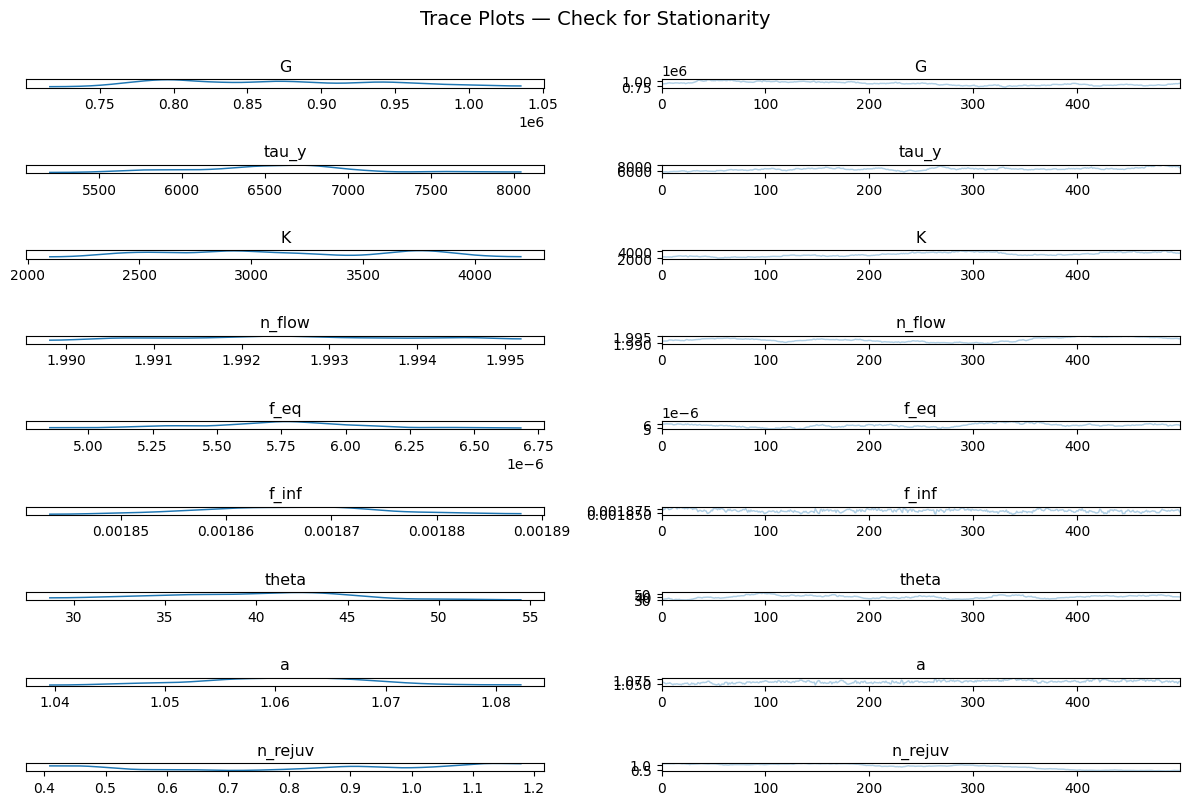

In [12]:
idata = result.to_inference_data()
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots — Check for Stationarity", fontsize=14, y=1.001)
plt.tight_layout()
plt.show()
plt.close('all')

#### Pair Plot (Parameter Correlations)

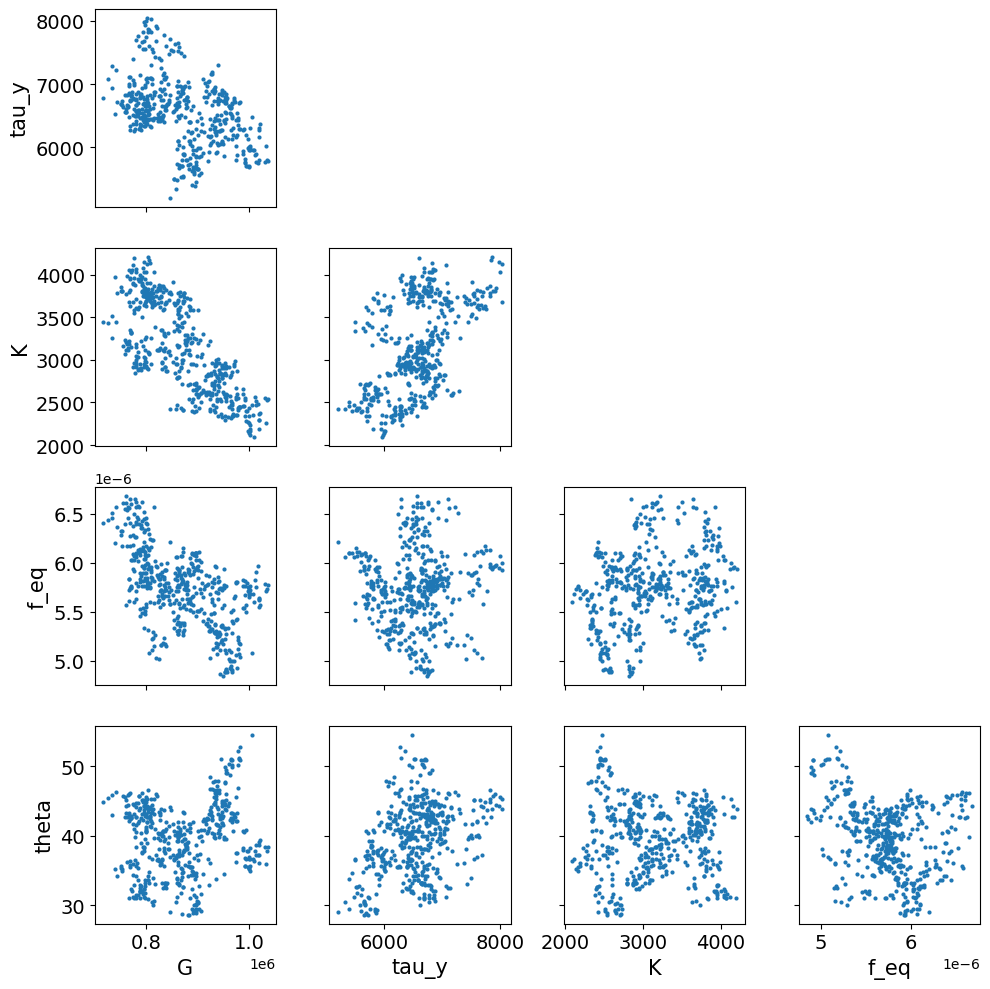

In [13]:
# Subset to key parameters for clarity
key_params = ["G", "tau_y", "K", "f_eq", "theta"]
axes = az.plot_pair(
    idata,
    var_names=key_params,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
plt.show()
plt.close('all')

#### Forest Plot (Credible Intervals)

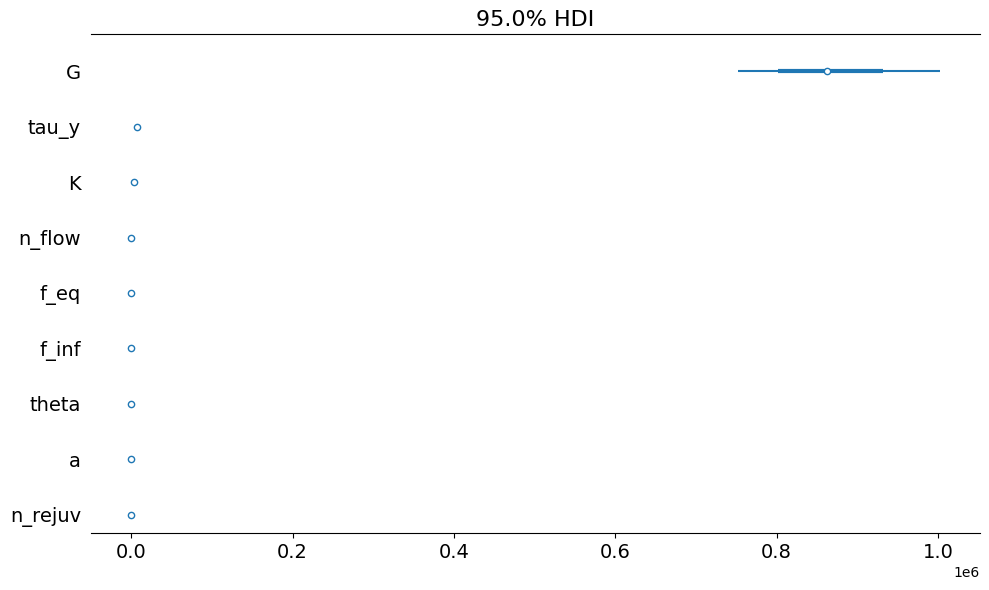

In [14]:
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 6),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
plt.show()
plt.close('all')

## 7. Posterior Predictive

Visualize uncertainty in stress predictions by sampling from the posterior distribution.

In [15]:
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
t_pred = np.linspace(t_data.min(), t_data.max(), 100)

print(f"Generating posterior predictions ({n_draws} draws)...")

# Sample predictions
pred_samples = []
for i in range(n_draws):
    # Set parameters from posterior draw i
    params_i = jnp.array([posterior[name][i] for name in param_names])

    # Predict using model_function
    pred_i = model.model_function(
        jnp.array(t_pred),
        params_i,
        test_mode="startup",
    gamma_dot=GAMMA_DOT,
    )
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

print("Posterior predictive statistics:")
print(f"  Median peak stress: {pred_median.max():.2f} Pa")
print(f"  95% CI width at peak: {pred_hi.max() - pred_lo.max():.2f} Pa")

Generating posterior predictions (200 draws)...


Posterior predictive statistics:
  Median peak stress: 5488.65 Pa
  95% CI width at peak: 58.90 Pa


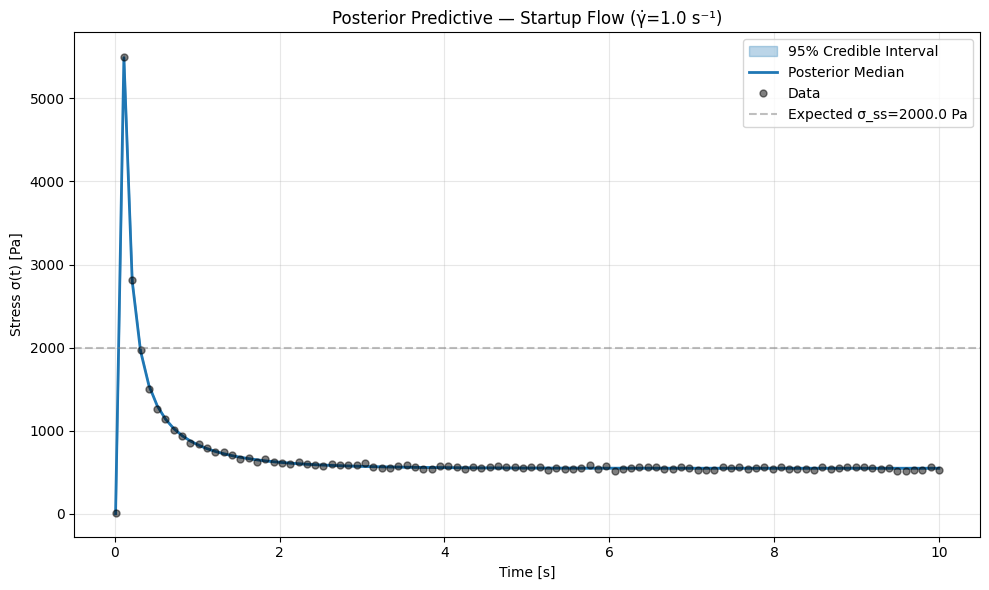

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

# Posterior predictive bands
ax.fill_between(
    t_pred,
    pred_lo,
    pred_hi,
    alpha=0.3,
    color="C0",
    label="95% Credible Interval",
)
ax.plot(t_pred, pred_median, "-", lw=2, color="C0", label="Posterior Median")

# Data
ax.plot(t_data, stress_data, "ko", markersize=5, alpha=0.5, label="Data")

# Expected steady state
ax.axhline(
    sigma_ss_expected,
    color="gray",
    linestyle="--",
    alpha=0.5,
    label=f"Expected σ_ss={sigma_ss_expected:.1f} Pa",
)

ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress σ(t) [Pa]")
ax.set_title(f"Posterior Predictive — Startup Flow (γ̇={GAMMA_DOT} s⁻¹)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close('all')

## 8. Save Results

Save NLSQ parameters and posterior samples for use in other notebooks.

In [17]:
save_fluidity_results(
    model=model,
    result=result,
    model_variant="local",
    protocol="startup",
    param_names=param_names,
)

# Compute and save fit quality metrics
fit_quality = compute_fit_quality(stress_data, stress_pred_data)
print(f"\nFit quality metrics:")
print(f"  R² = {fit_quality['R2']:.6f}")
print(f"  RMSE = {fit_quality['RMSE']:.4g} Pa")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fluidity/local/startup/
  nlsq_params_startup.json: 9 parameters
  posterior_startup.json: 500 draws

Fit quality metrics:
  R² = 0.976673
  RMSE = 87.25 Pa


## Key Takeaways

1. **Stress Overshoot**: Hallmark thixotropic signature — peak stress σ_max > steady-state σ_ss due to structural breakdown
2. **Coupled Dynamics**: Stress σ(t) and fluidity f(t) evolve together via viscoelastic and structural ODEs
3. **Physical Interpretation**:
   - **Overshoot magnitude**: Reflects degree of initial structure (low f_eq)
   - **Time to peak**: Inverse breakdown rate ~ 1/(a|γ̇|^n)
   - **Steady state**: f → f_ss = (f_eq/θ + a|γ̇|^n f_inf) / (1/θ + a|γ̇|^n)
4. **NLSQ Performance**: Fast (< 10s) convergence with proper warm-start from flow curve
5. **Bayesian Inference**: Critical to pass `gamma_dot` argument to `fit_bayesian()` for correct predictions
6. **Model Limitation**: Local model assumes homogeneous flow — use FluidityNonlocal for shear banding

### Physical Insights

- **Aging term**: (f_eq - f)/θ → structural recovery at rest (f → f_eq)
- **Rejuvenation term**: a|γ̇|^n(f_inf - f) → shear-induced breakdown (f → f_inf)
- **Timescale separation**: θ (aging, ~10s) vs 1/(a|γ̇|^n) (rejuvenation, <1s at high γ̇)

### Next Steps

- **Notebook 03**: Creep compliance (stress-controlled deformation)
- **Notebook 04**: Stress relaxation (step strain response)
- **Notebook 05**: SAOS (small amplitude oscillatory shear)
- **Notebook 06**: LAOS (large amplitude for nonlinear viscoelasticity)
- Explore multi-shear-rate fitting for global parameter estimation
- Investigate shear banding with FluidityNonlocal model